In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## CuPy

In [2]:
kernel=cp.ElementwiseKernel(
    'float32 r,float32 x','float32 new_x',
        '''new_x = r * x * (1-x)''',
    'my_kernel')

In [3]:
def return_last_points(kernel, r, x0, n, m):
    x = x0
    xsave = []
    for i in np.arange(n + m):
        x = kernel(r, x)
        if i > n:
            xsave.append(x)

In [4]:
import cProfile
r_space = cp.linspace(2, 4, 4000, dtype='f')
x_space = cp.ones(4000, dtype='f')*0.5
cProfile.run('return_last_points(kernel, r_space, x_space, 200, 100)')

         189 function calls in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.002    0.002 1300334232.py:1(return_last_points)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 _collections_abc.py:657(get)
        1    0.000    0.000    0.000    0.000 compiler.py:114(_get_nvrtc_version)
        2    0.000    0.000    0.000    0.000 compiler.py:213(_get_bool_env_variable)
        2    0.000    0.000    0.000    0.000 compiler.py:268(_hash_hexdigest)
        1    0.000    0.000    0.000    0.000 compiler.py:447(get_cache_dir)
        1    0.000    0.000    0.000    0.000 compiler.py:463(_compile_module_with_cache)
        1    0.000    0.000    0.000    0.000 compiler.py:494(_compile_with_cache_cuda)
        1    0.000    0.000    0.000    0.000 genericpath.py:16(exists)
        1    0.000    0.000    0.000    0.000 genericp

In [5]:
sizes = np.logspace(1, 6, 20)
cp_time = []

for n in tqdm(sizes):
    r_space = cp.linspace(0, 4, int(n), dtype='f')
    x_space = cp.ones(int(n), dtype='f') * 0.5
    t_cp = %timeit -o -n 100 -r 4 -q return_last_points(kernel, r_space, x_space, 200, 100)
    cp_time.append(t_cp)

100%|███████████████████████████████████████████| 20/20 [00:18<00:00,  1.05it/s]


## NumPy

In [6]:
def logistic_function(r, x):
    return r*x*(1-x)

def return_last_points_ordinary(map_function, r, x0, n, m):
    xsave = []
    x = x0
    for i in np.arange(n + m):
        x = map_function(r, x)
        if i > m:
            xsave.append(x)
    return xsave

def eval_rs(rs):
    for r in rs:
        xx = return_last_points_ordinary(logistic_function, r, 0.5, 200, 100)

In [7]:
np_time = []
for n in tqdm(sizes[:10]):
    rs = np.linspace(0, 4, int(n))
    t_np = %timeit -o -n 5 -r 4 -q eval_rs(rs)
    np_time.append(t_np)

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


## MPI
I will use 4 processes as it proved to be the optimal amount.

In [8]:
%%writefile logistic_map.py

# MPI implementation

import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
import time
import sys


def logistic_map(x, r):
    return r*x*(1-x)

def bm_np(points=400, rs=None):
    # I will skip first 500 values and then plot following 32 values
    if rs is None:
        rs = np.linspace(0, 3.99, points)
        xn = np.array([0.5]*points)
    else:
        xn = np.array([0.5]*len(rs))
    n = 500  # skip first 500 values
    m = 32  # save last 32 values

    xs = np.zeros(points*m)
    ys = np.zeros(points*m)
        
    # skip first "n" values
    for _ in range(n):
        xn = logistic_map(xn, rs)
    
    # save last "m" values
    for i in range(m):
        ys[i*points : (i+1)*points] = xn
        xs[i*points : (i+1)*points] = rs
        xn = logistic_map(xn, rs)
    
    return xs, ys


def main(points):
    # Mantra
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    samples = points
    m = 32

    # Data preparation
    if rank == 0:
        rs = np.linspace(0, 3.99, samples)

        # count the size of the array of each process
        quot, rem = divmod(samples, size)
        chunk_sizes = [quot + 1 if i < rem else quot for i in range(size)]
        chunk_sizes = np.array(chunk_sizes)

        # the starting index of each process (displacement or shift)
        chunk_displs = [sum(chunk_sizes[:i]) for i in range(size)]
        chunk_displs = np.array(chunk_displs)
        
        ys_sizes = chunk_sizes*m
        ys_displs = chunk_displs*m
        
        ys = np.zeros(samples*m, dtype=np.double)
        xs = np.zeros(samples*m, dtype=np.double)
    else:      
        chunk_sizes = np.zeros(size, dtype=int)
        ys_sizes = np.zeros(size, dtype=int)
        
        rs = None
        chunk_displs = None
        ys_displs = None
        ys = None
        xs = None
    
    # Broadcasting
    comm.Bcast(chunk_sizes)
    comm.Bcast(ys_sizes)
    
    # buffer for scattering
    rs_chunk = np.zeros(chunk_sizes[rank], dtype=np.double)
    
    # Scattering data
    comm.Scatterv([rs, chunk_sizes, chunk_displs, MPI.DOUBLE], rs_chunk)
    
    # Parallel computing
    xs_chunk, ys_chunk = bm_np(chunk_sizes[rank], rs_chunk)
    
    # Gathering back
    comm.Gatherv(ys_chunk, [ys, ys_sizes, ys_displs, MPI.DOUBLE])
    comm.Gatherv(xs_chunk, [xs, ys_sizes, ys_displs, MPI.DOUBLE])
    
    # Saving
    if rank == 0:
        return (xs, ys)
    return None


if __name__ == "__main__":
    if len(sys.argv) == 2:
        points = int(sys.argv[1])
    else:
        points = 400
    
    # Logistic map calculation
    start = time.perf_counter()
    ans = main(points)
    elapsed = time.perf_counter() - start
    
    if MPI.COMM_WORLD.Get_rank() == 0:
        print(elapsed)

Overwriting logistic_map.py


In [9]:
mpi_time = []
for n in tqdm(sizes):
    size = int(n)
    t_mpi = ! mpiexec -n 4 python3 ./logistic_map.py $size
    mpi_time.append(float(t_mpi[0]))

100%|███████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]


In [10]:
np_time

[<TimeitResult : 1.39 ms ± 318 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 2.17 ms ± 7.02 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 3.99 ms ± 6.47 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 7.33 ms ± 19.7 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 13.5 ms ± 85.7 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 24.7 ms ± 389 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 44.9 ms ± 187 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 82.2 ms ± 182 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 149 ms ± 805 µs per loop (mean ± std. dev. of 4 runs, 5 loops each)>,
 <TimeitResult : 276 ms ± 2.34 ms per loop (mean ± std. dev. of 4 runs, 5 loops each)>]

In [11]:
cp_time

[<TimeitResult : 1.82 ms ± 21.2 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.79 ms ± 11.1 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.82 ms ± 6.33 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.84 ms ± 10.7 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.84 ms ± 2.65 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.84 ms ± 9.52 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.83 ms ± 23.6 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.82 ms ± 10.6 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.84 ms ± 12.1 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.8 ms ± 10.8 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,
 <TimeitResult : 1.74 ms ± 19.3 µs per loop (mean ± std. dev. of 4 runs, 100 loops each)>,


In [12]:
mpi_time

[0.004198608992737718,
 0.007470926997484639,
 0.0012826360034523532,
 0.002071808004984632,
 0.001585648991749622,
 0.04334483500861097,
 0.016174032993149012,
 0.0016821199969854206,
 0.0018334269989281893,
 0.03032633601105772,
 0.003805405998718925,
 0.006999345001531765,
 0.011002433995599858,
 0.007977675006259233,
 0.01512885800912045,
 0.041039233008632436,
 0.045124498996301554,
 0.12889277999056503,
 0.27476926799863577,
 0.5588693609897746]

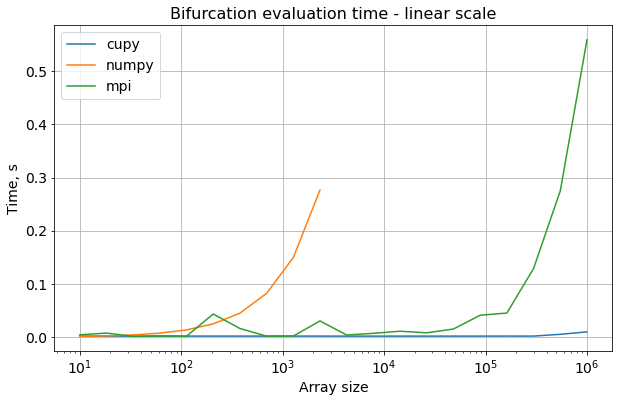

In [17]:
plt.figure(figsize=(10,6))
plt.plot(sizes, [i.average for i in cp_time])
plt.plot(sizes[:10], [i.average for i in np_time])
plt.plot(sizes, mpi_time)
plt.title('Bifurcation evaluation time - linear scale', fontsize=16)
plt.xlabel('Array size', fontsize=14)
plt.xscale('log')
plt.ylabel('Time, s', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['cupy', 'numpy', 'mpi'], fontsize=14);
plt.grid()
plt.show()

CuPy wins!